In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold,TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
# from imblearn.over_sampling import RandomOverSampler, SMOTE 

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc, warnings, time
# warnings.filterwarnings("ignore", message="categorical_feature in Dataset is overridden")
# warnings.filterwarnings("ignore", message="categorical_feature in param dict is overridden")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 100)

random_state = 42

warnings.filterwarnings("ignore", message="categorical_feature in Dataset is overridden")
# warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples")
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
def get_class_from_prob(y_prob):
        return  [0  if x < 0.5 else 1 for x in y_prob]


def write_predictions(sub, y_prob, filename ):          
#     sub_prob = sub.copy()
    sub[TARGET] = y_prob    
    sub.to_csv( filename, index = False)
    
    y_pred =   get_class_from_prob(y_prob) 
    print('Test prediction:Postive class count {}, Percent {:0.2f}'.format(sum(y_pred), sum(y_pred) * 100 / len(y_pred)))
    return sub

def set_ordinal_encoding(data, cat_cols):   
   
    for col in [x for x in cat_cols if data[x].dtype == 'object']:
        data[col], uniques = pd.factorize(data[col])
        #the factorize sets null values to -1, so convert them back to null, as we want LGB to handle null values
        data[col] = data[col].replace(-1, np.nan)
    print('Finished: Ordinal Encoding')

    return data

def get_train_test(df, features, ID):
    X_train =  df[df[TARGET].notnull()]
    X_test  =  df[df[TARGET].isnull()]
    y_train = X_train[TARGET]
    sub = pd.DataFrame()
    sub[ID] = X_test[ID]
    X_train = X_train[features]
    X_test = X_test[features]
    return X_train, X_test, y_train, sub

def plot_feature_imp(feature_imp, top_n = 30):
    feature_imp = feature_imp.sort_values(['importance'], ascending = False)
    feature_imp_disp = feature_imp.head(top_n)
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=feature_imp_disp)
    plt.title('LightGBM Features')
    plt.show() 
    
    
def cv_results(y_valid, y_prob, verbose = True):   
    scores = {}                      
    y_pred_class =  [0  if x < 0.5 else 1 for x in y_prob]
    scores['cv_accuracy']  = accuracy_score(y_valid, y_pred_class)
    scores['cv_auc']       = roc_auc_score(y_valid, y_prob)
    scores['cv_f1']      =   f1_score(y_valid, y_pred_class, average = 'binary')
    if verbose:
        print('CV accuracy {:0.6f}'.format( scores['cv_accuracy'] ))
        print('CV AUC  {:0.6f}'.format( scores['cv_auc']   ))
        print('CV F1 %0.6f' %scores['cv_f1'] )
    return scores  


def run_lgb_with_cv(params, X_train, y_train, X_test,cat_cols, oversample =False ,shuffle_split = True, 
                    test_size =0.2, verbose_eval = 100, ):
    
    if shuffle_split: 
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size , 
                                                  random_state = random_state, stratify = y_train)
    else:
        #since data is sorted according to time, the split will be according to time with shuffle = False
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = test_size , 
                                                      random_state = random_state, shuffle = False)
         
    
    if oversample:
        ros = RandomOverSampler(random_state= random_state)
    #     sm = SMOTE(random_state= random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        X_train = pd.DataFrame(X_train, columns = X_valid.columns.tolist())
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid  = lgb.Dataset(X_valid, y_valid)
    early_stopping_rounds = 300
    lgb_results = {}    

    print('Train shape{} Valid Shape{}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))
    print('Number of Category Columns {}:'.format(len(cat_cols)))
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round = 10000,
                      valid_sets =  [lgb_train,lgb_valid],  #Including train set will do early stopiing for train instead of validation
                      early_stopping_rounds = early_stopping_rounds,                      
                      categorical_feature = cat_cols,
                      evals_result = lgb_results,
                      verbose_eval = verbose_eval
                       )
    y_prob_valid = model.predict(X_valid)    
    cv_results(y_valid, y_prob_valid, verbose = True)
  
    feature_imp = pd.DataFrame()
    feature_imp['feature'] = model.feature_name()
    feature_imp['importance']  = model.feature_importance()
    feature_imp = feature_imp.sort_values(by = 'importance', ascending= False )
    return model, feature_imp

def run_lgb_no_cv(params, X_train, y_train, X_test,cat_cols, oversample = False, num_rounds = 100, verbose_eval = 100, ):  
    if oversample:
        ros = RandomOverSampler(random_state= random_state)
    #     sm = SMOTE(random_state= random_state)
        columns = X_train.columns.tolist()
        X_train, y_train = ros.fit_resample(X_train, y_train)
        X_train = pd.DataFrame(X_train, columns = columns)
      
    print('Train shape{}  Test Shape {}'.format(X_train.shape, X_test.shape))
    print('Number of Category Columns {}, Number of Rounds {}:'.format(len(cat_cols), num_rounds))

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_results = {}    

    warnings.filterwarnings("ignore", message="categorical_feature in Dataset is overridden")
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round = num_rounds,                 
                      categorical_feature = cat_cols,
                      evals_result = lgb_results,
                      valid_sets =  [lgb_train],
                      verbose_eval = verbose_eval
                       )
  
    feature_imp = pd.DataFrame()
    feature_imp['feature'] = model.feature_name()
    feature_imp['importance']  = model.feature_importance()
    feature_imp = feature_imp.sort_values(by = 'importance', ascending= False )
    return model, feature_imp

def combine_cols(col1, col2, df):
    col = col1 + '_' + col2
    df[col] = df[col1].astype(str) + '_'  + df[col2].astype(str)
    return df, col


def lgb_nfolds(params, X_train, y_train, X_test,  cat_cols = [], oversample = False,
               stratifiedKFold = False, nfolds = 5, verbose_eval = 100, predict_test_set = True, early_stopping_rounds = 250 ):
    if stratifiedKFold:
       folds = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state = random_state)   
    else:
       folds = KFold(n_splits = nfolds, shuffle = True, random_state = random_state)

    oof_prob = np.zeros(shape=(X_train.shape[0])) 
    cv_score = np.zeros(shape = nfolds)
    test_prob = np.zeros(shape=(X_test.shape[0]))
    feature_imp = pd.DataFrame()   

    print('Train Shape {}, Test shape {}'.format(X_train.shape, X_test.shape )) 
    print('Number of Category Columns {}:'.format(len(cat_cols)))
    warnings.filterwarnings("ignore", message="Overriding the parameters from Reference Dataset")
    warnings.filterwarnings("ignore", message="categorical_column in param dict is overridden")

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx],  y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx],  y_train.iloc[valid_idx]   
        
        if oversample:           
#             ros = RandomOverSampler(random_state=42)
            sm = SMOTE(random_state= random_state)
            train_x, train_y = sm.fit_resample(train_x, train_y)
            train_x = pd.DataFrame(train_x, columns = X_train.columns.tolist())
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_valid  = lgb.Dataset(valid_x, valid_y)
        
        lgb_results = {}
        
        print('\nTrain Shape {}, Valid shape {}'.format(train_x.shape, valid_x.shape )) 
        model = lgb.train(params,
                          lgb_train,
                          num_boost_round = 10000,
                          valid_sets =  [lgb_train,lgb_valid],
#                           valid_sets =  [lgb_valid],
                          early_stopping_rounds = early_stopping_rounds,                    
                          categorical_feature = cat_cols,                    
                          evals_result = lgb_results,
#                           feval = lgb_f1_score,
                          verbose_eval = verbose_eval
                           )

        oof_prob[valid_idx] = model.predict(valid_x) 
        y_pred =   get_class_from_prob(oof_prob[valid_idx])
        print('Valid Set:Postive class count {}, Percent {:0.2f}'.format(sum(valid_y), sum(valid_y) * 100 / len(valid_y)))
        print('Valid Predict :Postive class count {}, Percent {:0.2f}'.format(sum(y_pred), sum(y_pred) * 100 / len(y_pred)))
        if predict_test_set:                            
            #Average out the test set probablities  
            test_prob += model.predict(X_test) / folds.n_splits        
    
        fold_importance = pd.DataFrame()
        fold_importance["feature"] =  model.feature_name()
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = n_fold + 1   
        feature_imp = pd.concat([feature_imp, fold_importance], axis=0)
        
        print('Fold {}'.format(n_fold+1), end =' ')
        scores = cv_results(valid_y, oof_prob[valid_idx], verbose = False)
        cv_score[n_fold] = round(scores['cv_auc'], 6)
        print('Validation AUC {:0.6f}'.format(cv_score[n_fold]))  
           
    print('\nScores:', cv_score)
    print('Mean AUC Score{:0.6f}: '.format(np.mean(cv_score))) 
    print('Out of Fold  CV results') 
    cv_results(y_train, oof_prob, verbose = True)
    
    y_pred =   get_class_from_prob(oof_prob)   
    print('OOF prediction:Postive class count {}, Percent {:0.2f}'.format(sum(y_pred), sum(y_pred) * 100 / len(y_pred)))

    feature_imp = feature_imp[['feature', 'importance']].groupby(['feature']).mean().reset_index()
    feature_imp.sort_values(['importance'], ascending= False, inplace = True)
    return oof_prob, test_prob, feature_imp   


## Read Data

In [23]:
data_path = "C:\\Users\\I056036\\OneDrive - SAP SE\\Documents\\Docs\\Development\\datasets\\AV VehicleInsurance\\data"
output_path = "C:\\Users\\I056036\\OneDrive - SAP SE\\Documents\\Docs\\Development\\datasets\\AV VehicleInsurance\\outputs"

train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))

data = train.append(test, ignore_index = True, sort=False)

print('Train  Data - rows:', train.shape[0], 'columns:', train.shape[1])
print('Test  Data - rows:', test.shape[0], 'columns:', test.shape[1])
print('Data - rows:', data.shape[0], 'columns:', data.shape[1])

Train  Data - rows: 381109 columns: 12
Test  Data - rows: 127037 columns: 11
Data - rows: 508146 columns: 12


## Data Preprocessing

In [24]:
TARGET = 'Response'
cols = train.columns.tolist()
categorical_cols = [ 'Gender',  'Driving_License', 'Region_Code', 'Previously_Insured',  'Vehicle_Damage',  'Policy_Sales_Channel',  'Vehicle_Age']
numerical_cols = ['Age',   'Annual_Premium', 'Vintage']

In [25]:
# New Features
freq_cols = ['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']
for col in freq_cols:
    new_col = col + '_count'
    data[new_col] = data[col].map(data[col].value_counts(dropna=False)) 
    numerical_cols.append(new_col)

In [26]:

features = categorical_cols + numerical_cols  


data = set_ordinal_encoding(data, categorical_cols)
X_train, X_test, y_train, sub = get_train_test(data, features, 'id')
print('Train Shape {}, Test Shape {}'.format(X_train.shape, X_test.shape))



Finished: Ordinal Encoding
Train Shape (381109, 13), Test Shape (127037, 13)


## LGB 5- Fold

In [27]:
%%time

params = {}

# params['bagging_fraction'] = 0.8
# params['bagging_freq'] = 3
# params['feature_fraction'] = 0.8
# params['lambda_l1'] = 0.15
# params['lambda_l2'] = 4.76
# params['max_bin'] = 511
# params['min_data_in_leaf'] = 189
# params['min_gain_to_split'] = 5.95
# params['min_sum_hessian_in_leaf'] = 6.0
# params['scale_pos_weight'] = 1.4

params['learning_rate'] =  0.05
# params['num_leaves'] = 16
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['seed'] =  random_state
params['metric'] = 'auc'
params['verbose'] = -1



cat_cols = categorical_cols.copy()
# cat_cols.remove('Policy_Sales_Channel')
oof_prob, y_prob_test, feature_imp  = lgb_nfolds(params, X_train, y_train, X_test,  cat_cols , stratifiedKFold = True, 
                                                 nfolds = 5, verbose_eval = 100, predict_test_set = True,  early_stopping_rounds = 300 )



Train Shape (381109, 13), Test shape (127037, 13)
Number of Category Columns 7:

Train Shape (304887, 13), Valid shape (76222, 13)
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.864469	valid_1's auc: 0.85731
[200]	training's auc: 0.868372	valid_1's auc: 0.857207
[300]	training's auc: 0.872634	valid_1's auc: 0.857047
[400]	training's auc: 0.877203	valid_1's auc: 0.856745
Early stopping, best iteration is:
[148]	training's auc: 0.866134	valid_1's auc: 0.857383
Valid Set:Postive class count 9342.0, Percent 12.26
Valid Predict :Postive class count 73, Percent 0.10
Fold 1 Validation AUC 0.857383

Train Shape (304887, 13), Valid shape (76222, 13)
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.864755	valid_1's auc: 0.856831
[200]	training's auc: 0.86888	valid_1's auc: 0.85691
[300]	training's auc: 0.872933	valid_1's auc: 0.856769
[400]	training's auc: 0.877187	valid_1's auc: 0.856526
Early stopping, best iteration i

Test prediction:Postive class count 115, Percent 0.09


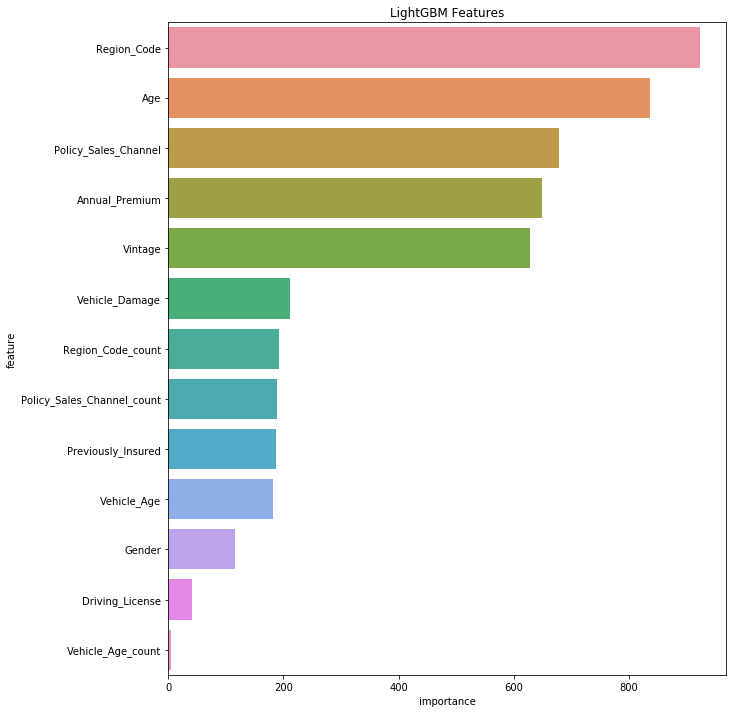

{'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'binary', 'seed': 42, 'metric': 'auc', 'verbose': -1}


In [28]:
out_file = os.path.join(output_path, 'lgb_results.csv')
sub = write_predictions(sub,y_prob_test, out_file )
plot_feature_imp(feature_imp, top_n = 30)
print(params)

In [29]:
sub.head(20)

,id,Response
381109,381110,0.000579
381110,381111,0.329201
381111,381112,0.294035
381112,381113,0.003167
381113,381114,0.000434
381114,381115,0.000347
381115,381116,0.000574
381116,381117,0.000393
381117,381118,0.372077
381118,381119,0.003499
